IMPORTED LIBRARIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import copy
import time
import torch.optim as optim

Here we will use Transfer Learning..i.e..using predefined RESNET model with a small variation in output layer. For Resnet we need the 
size of input image to be 224 X 224 and also necessary transformations.

In [2]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

The dataset is already divided into train, val and test folders. Also two subfolders of 'NORMAL' and 'Pneumonia' in each folder. We just need to open the Imagefolder to define dataset.

In [3]:
trainset = torchvision.datasets.ImageFolder("../input/chest-xray-pneumonia/chest_xray/train", transform = transform)
valset = torchvision.datasets.ImageFolder("../input/chest-xray-pneumonia/chest_xray/val", transform = transform)
testset = torchvision.datasets.ImageFolder("../input/chest-xray-pneumonia/chest_xray/test", transform = transform)

We fixed the batch_size to be 128. Larger batch size gives us more accurate results but they are a bit slower...Smaller batch size performance is faster. This means that training will be faster.

In [4]:
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
evalloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

Just visuslised the shapes of images and labels

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 224, 224])
torch.Size([128])


Defined the two classes.

In [6]:
classes = ['Normal', 'Pneumonia']

Loaded RESNET model

In [7]:
model = torchvision.models.resnet50(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [8]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

As we have loaded pretrained model the weights need not to be trained again...So we set it to False

In [9]:
for p in model.parameters():
    p.requires_grad = False


Here we are dealing with 2 classes...but in resnet model there are 1000 classes in output layer. So we will redefine model.fc layer(last layer) by adding several layers and 2 classes at the end...

In [10]:
model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256,2)
    
)

Checked for GPU

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Model transeferred to device

In [12]:
model = model.to(device)

We are using CrossEntropyloss function here.. We use this loss function for classification problem. This loss function is a combination of Softmax and Negative logloss likelihood(nn.NLLLoss) loss function.

In [13]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr = 0.001)

Defined evaluation function for calculating accuracy.

In [14]:
def evaluation(dataloader):
    total, correct = 0,0
    model.eval()
    for data in dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100*correct/total

Trained the model and saved the best model ..

In [15]:
%%time
loss_train_arr = []
loss_val_arr = []

max_epochs = 10
min_val_loss = 1000
for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs,labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        model.train()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        model.eval()
        for j in evalloader:
            images_val, labels_val = j
            images_val, labels_val = images_val.to(device), labels_val.to(device)
            output_val = model(images_val)
            val_loss = loss_fn(output_val, labels_val)
            if min_val_loss > val_loss.item():
                min_val_loss = val_loss.item()
                best_model = copy.deepcopy(model.state_dict())
                print('Train loss %0.2f' % loss.item(), end = " ")
                print('Min val loss %0.2f' % min_val_loss)  
                del inputs, labels, outputs, images_val, labels_val, output_val
                torch.cuda.empty_cache()
    loss_val_arr.append(val_loss.item())
    loss_train_arr.append(loss.item())
    model.eval()
        
    print('Epoch: %d/%d, Train acc: %0.2f, eval acc: %0.2f' % (
        epoch+1, max_epochs, 
        evaluation(trainloader), evaluation(evalloader)))
    


Train loss 0.67 Min val loss 1.20
Train loss 0.63 Min val loss 0.75
Train loss 0.44 Min val loss 0.58
Train loss 0.29 Min val loss 0.46
Train loss 0.24 Min val loss 0.40
Train loss 0.15 Min val loss 0.24
Epoch: 1/10, Train acc: 93.81, eval acc: 62.50
Epoch: 2/10, Train acc: 95.61, eval acc: 81.25
Epoch: 3/10, Train acc: 96.15, eval acc: 62.50
Train loss 0.18 Min val loss 0.23
Train loss 0.14 Min val loss 0.22
Train loss 0.12 Min val loss 0.17
Train loss 0.16 Min val loss 0.15
Epoch: 4/10, Train acc: 95.95, eval acc: 56.25
Train loss 0.07 Min val loss 0.12
Epoch: 5/10, Train acc: 96.13, eval acc: 62.50
Epoch: 6/10, Train acc: 96.64, eval acc: 81.25
Epoch: 7/10, Train acc: 96.38, eval acc: 56.25
Epoch: 8/10, Train acc: 96.97, eval acc: 81.25
Train loss 0.04 Min val loss 0.09
Epoch: 9/10, Train acc: 97.45, eval acc: 68.75
Train loss 0.04 Min val loss 0.09
Train loss 0.09 Min val loss 0.08
Epoch: 10/10, Train acc: 95.95, eval acc: 50.00
CPU times: user 40min 32s, sys: 1min 22s, total: 41mi

Visualised train and val losses...

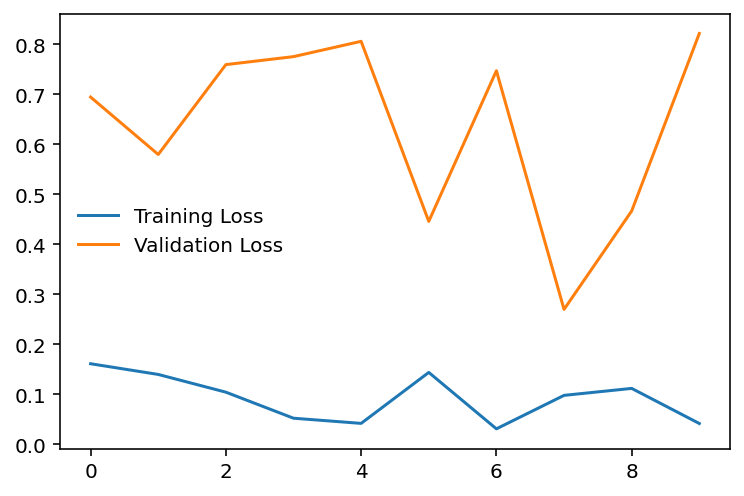

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(loss_train_arr, label='Training Loss')
plt.plot(loss_val_arr, label='Validation Loss')
plt.legend(frameon=False)

Loaded the best model and found accuracy of test dataset..

In [17]:
model.load_state_dict(best_model)
print(evaluation(testloader))

88.30128205128206


Model is completely ready...

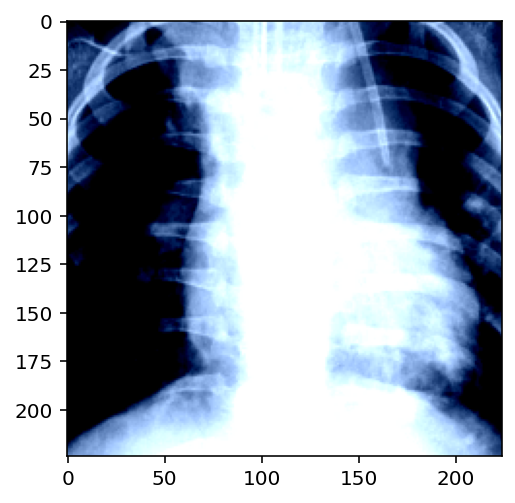

Ground_Truth-
Pneumonia
Predicted class-
Pneumonia


In [18]:
classes = ['Normal', 'Pneumonia']
dataiter = iter(testloader)
images, labels = dataiter.next()
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
imshow(torchvision.utils.make_grid(images[:1]))
print("Ground_Truth-")
print(classes[labels[0]])
images = images.to(device)
output = model(images)
max_values, pred_class = torch.max(output.data, 1)
print("Predicted class-")
print(classes[pred_class[0]])